# Pharmacophoric points from protein-ligand interactions

In [1]:
import openpharmacophore.pharmacophore.pl_interactions as pli
import mdtraj as mdt
import nglview as nv
import numpy as np
from rdkit.Chem import AllChem as Chem

from view_feats import add_features_to_view, add_points_to_view

import os
from pprint import pprint

In [2]:
# Cutoff for determination of binding site atoms 
pli.BS_DIST = 0.55  # in nanometers
pli.HYDROPHOBE_DIST = 0.5

In [3]:
data_dir = "./data"

In [4]:
def load_ligand_from_sdf(file_path):
    """ Loads the first ligand from an sdf file. """
    sup = Chem.SDMolSupplier(os.path.join(data_dir, file_path))
    mols = [mol for mol in sup]
    return mols[0]

In [5]:
def print_traf_info(traj):
    """ Prints basic info of a trajectory. """
    print(f"Num atoms: {traj.n_atoms}")
    print(f"Num chains: {traj.n_chains}")
    print(f"Num residues: {traj.n_residues}")

In [6]:
def ligand_data(traj, lig_id):
    """ Returns the ligand centroid, indices and maximum extent."""
    lig_indices = pli.get_ligand_atom_indices(traj, lig_id)
    lig_centroid = pli.ligand_centroid(traj, lig_id)
    lig_extent = pli.ligand_maximum_extent(traj, lig_id)

    print(f"Ligand indices len {len(lig_indices)}")
    print(f"Ligand centroid: {lig_centroid}")
    print(f"Ligand maximum extent: {lig_extent}")
    
    return lig_indices, lig_centroid, lig_extent

In [7]:
def ligand_chem_features(traj, ligand, ligand_indices):
    """ Computes the chemical features for the ligand. """
    indices_mapper = dict(zip(list(range(ligand.GetNumAtoms()))
                              ,ligand_indices))
    ligand_features_rd = pli.chemical_features(ligand, pli.smarts_feat_def)

    # Map rdkit ligand indices to mdtraj's
    ligand_features = pli.map_ligand_features_indices(ligand_features_rd, indices_mapper)
    return pli.features_centroid(ligand_features, traj.xyz)

In [8]:
def view_ligand_with_feats(traj, ligand_indices, ligand_feats):
    """ Returns a view of the ligand with its chemical features as spheres."""
    ligand_traj = traj.atom_slice(ligand_indices)
    ligand_view = nv.show_mdtraj(ligand_traj)
    add_features_to_view(ligand_view, ligand_feats)
    return ligand_view

In [9]:
def binding_site_data(protein_mol, coords, lig_centroid, lig_extent):
    """ Returns the binding site indices and chemical features. """
    bs_indices = pli.get_binding_site_atoms_indices(
        lig_centroid, lig_extent, coords[0])
    print(f"Bs indices shape {bs_indices.shape}")
    
    bs_feats_indices = pli.chemical_features(protein_mol, pli.protein_smarts, bs_indices)
    bs_feats = pli.features_centroid(bs_feats_indices, coords)
    return bs_indices, bs_feats

In [10]:
def view_binding_site(traj, bs_indices, bs_feats, 
                      ligand_indices, ligand_feats):
    """ Returns a view of the binding site with the ligand and it's chemical features. 
    """
    bs_site_traj = traj.atom_slice(np.concatenate((bs_indices, np.array(ligand_indices))))
    feats_view = nv.show_mdtraj(bs_site_traj)
    add_features_to_view(feats_view, ligand_feats)
    add_features_to_view(feats_view, bs_feats)
    feats_view.representations = [
         {"type": "ball+stick", 
          "params": {
              "sele": "protein",
          }},
        {"type": "ball+stick", 
         "params": {
             "sele": "( not polymer or hetero ) and not ( water or ion )",
             # "color": "blue",
        }}
    ]
    return feats_view

In [11]:
def view_pharmacophoric_points(traj, bs_indices, ligand_indices, points, point_type):

    bs_site_traj = traj.atom_slice(np.concatenate((bs_indices, np.array(ligand_indices))))
    bs_view = nv.show_mdtraj(bs_site_traj)
    add_points_to_view(bs_view, points, point_type)
    bs_view.representations = [
         {"type": "ball+stick", 
          "params": {
              "sele": "all",
          }},
    ]
    return bs_view

## Hydrophobic pharmacophoric points

Hydrophobic pharmacophoric points in  HNF4 alpha ligand binding domain and lauric acid (PDB id 1M7W).

Num atoms: 1791
Num chains: 2
Num residues: 224


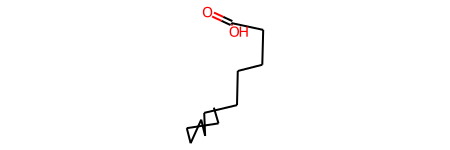

In [12]:
traj_1m7w = mdt.load(os.path.join(data_dir, "1m7w/1m7w_A_chain.pdb"))
mol_1m7w = Chem.MolFromPDBFile(os.path.join(data_dir, "1m7w/1m7w_A_chain.pdb"))
dao = load_ligand_from_sdf("1m7w/dao.sdf")
print_traf_info(traj_1m7w)
dao

In [13]:
pli.find_ligands_in_traj(traj_1m7w)

['DAO:B']

In [14]:
# Get all necessary ligand data
lig_id = "DAO:B"
dao_indices, dao_centroid, dao_extent = ligand_data(traj_1m7w, lig_id)

Ligand indices len 14
Ligand centroid: [6.3883634 2.9532642 1.2690858]
Ligand maximum extent: 0.6139441132545471


In [15]:
dao_feats = ligand_chem_features(traj_1m7w, dao, dao_indices)
# Keep only hydrophobic features
hyd_feats_dao = {
    "Hydrophobe": dao_feats["Hydrophobe"]
}

In [16]:
view_ligand_with_feats(traj_1m7w, dao_indices, hyd_feats_dao)

NGLWidget()

In [17]:
bs_indices_1m7w, bs_feats_1m7w = binding_site_data(mol_1m7w, traj_1m7w.xyz, dao_centroid, dao_extent)
bs_feats_hyd = {
    "Hydrophobe": bs_feats_1m7w["Hydrophobe"]
}

Bs indices shape (321,)


In [18]:
view_binding_site(traj_1m7w, bs_indices_1m7w, bs_feats_hyd, 
                  dao_indices, hyd_feats_dao)

NGLWidget()

### Get pharmacophoric points

In [21]:
hyd_points = pli.hydrophobic_pharmacophoric_points(hyd_feats_dao["Hydrophobe"],
                                                   bs_feats_hyd["Hydrophobe"]
                                                  )
print(f"Number of hydrophobic points {len(hyd_points)}")

Number of hydrophobic points 3


In [22]:
view_pharmacophoric_points(traj_1m7w, bs_indices_1m7w, dao_indices, 
                           hyd_points, "Hydrophobe")

NGLWidget()